In [2]:
# Librerias para la Manipulación de datos y visualización
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from datetime import datetime, timedelta
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#Libreria para pre-procesar datos (antes de entrenar el modelo)
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Librerias para evaluar modelos
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importar el modelo de Clasificación
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler

#Librerias para evaluar modelos
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_percentage_error, make_scorer



In [3]:
# Rutas
file_path = '/content/drive/MyDrive/SAP_Descuadres_Input/Historico_Consolidado_Copec.csv'
RUTA_SALIDA_MODELO = '/content/drive/MyDrive/SAP_Descuadres_Input/modelo_descuadres.pkl'
RUTA_SALIDA_REPORTES = '/content/drive/MyDrive/SAP_Descuadres_Input/reportes/'

In [4]:
df = pd.read_csv(file_path, sep=';')
print(df.head())
df.info()

  Fecha Contable Centro Producto Copec  Material Cantidad        Fecha Version
0     2025-10-01   C003          MUEVO         3    0,001  2025-12-22 21:53:12
1     2025-10-01   C006          MUEVO         3   -0,001  2025-12-22 21:53:12
2     2025-10-01   C006            TAE        16    -7619  2025-12-22 21:53:12
3     2025-10-01   C006            TCT        16     7619  2025-12-22 21:53:12
4     2025-10-01   C008            TAE        16   -24115  2025-12-22 21:53:12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609195 entries, 0 to 609194
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Fecha Contable  609195 non-null  object
 1   Centro          609195 non-null  object
 2   Producto Copec  569475 non-null  object
 3   Material        609195 non-null  int64 
 4   Cantidad        609195 non-null  object
 5   Fecha Version   609195 non-null  object
dtypes: int64(1), object(5)
memory usage: 27.9+ MB


In [5]:
## NORMALIZACIÓN: CONFIGURACIÓN, LIMPIEZA DE DATOS Y CORRECCIÓN DE TIPOS

# Normalización de productos (TCT y TAE -> TCT_TAE)

df['Producto Copec'] = df['Producto Copec'].replace(['TCT', 'TAE'], 'TCT_TAE')
print(df['Producto Copec'].value_counts())

# Limpieza de la columna Cantidad

if df['Cantidad'].dtype == 'object':
   df['Cantidad'] = df['Cantidad'].str.replace(',', '.', regex=False)
   df['Cantidad'] = pd.to_numeric(df['Cantidad'], errors='coerce').fillna(0)

# Conversión de fechas

df['Fecha Contable'] = pd.to_datetime(df['Fecha Contable'], format='%Y-%m-%d', errors='coerce')
df['Fecha Version'] = pd.to_datetime(df['Fecha Version'], errors='coerce')

# Convertir Material a string para OHE

df['Material'] = df['Material'].astype(str)

# Agregación por día/centro/producto

df = df.groupby(['Fecha Contable', 'Centro', 'Material', 'Producto Copec'], as_index=False).agg({
    'Cantidad': 'sum',
    'Fecha Version': 'max'
})
print(f"Datos después de agregación: {len(df):,} registros")

Producto Copec
MUEVO      276124
TCT_TAE    203708
CUPON       61865
FFAA        26520
VIRTUAL      1247
DDRR            7
TR              4
Name: count, dtype: int64
Datos después de agregación: 316,439 registros


In [6]:
## FEATURE ENGINEERING

# Features temporales

df['Dia_Semana'] = df['Fecha Contable'].dt.dayofweek
df['Dia_Mes'] = df['Fecha Contable'].dt.day
df['Es_Fin_Semana'] = (df['Dia_Semana'] >= 5).astype(int)
df['Es_Fin_Mes'] = (df['Dia_Mes'] >= 28).astype(int)
df['Mes'] = df['Fecha Contable'].dt.month
df['Periodo'] = df['Fecha Contable'].dt.to_period('M')

# Features de cantidad

df['Cantidad_Abs'] = df['Cantidad'].abs()
df['Es_Cantidad_Negativa'] = (df['Cantidad'] < 0).astype(int)

# Features de agregación por Centro

centro_stats = df.groupby('Centro')['Cantidad'].agg([
    ('Centro_Mean', 'mean'),
    ('Centro_Std', 'std'),
    ('Centro_Count', 'count')
]).reset_index()
df = df.merge(centro_stats, on='Centro', how='left')
df['Centro_Std'] = df['Centro_Std'].fillna(0)

# Features de agregación por Producto

producto_stats = df.groupby('Producto Copec')['Cantidad'].agg([
    ('Producto_Mean', 'mean'),
    ('Producto_Std', 'std')
]).reset_index()
df = df.merge(producto_stats, on='Producto Copec', how='left')
df['Producto_Std'] = df['Producto_Std'].fillna(0)

print(df.head())

  Fecha Contable Centro Material Producto Copec  Cantidad       Fecha Version  \
0     2022-11-19   G348        1          CUPON   -23.980 2025-12-22 21:44:25   
1     2022-11-19   G348       13          CUPON  -871.600 2025-12-22 21:44:25   
2     2022-11-19   G348        3          CUPON   -39.970 2025-12-22 21:44:25   
3     2022-11-19   G403       13          CUPON  -155.390 2025-12-22 21:44:25   
4     2022-11-20   G348        1          CUPON   177.055 2025-12-22 21:44:25   

   Dia_Semana  Dia_Mes  Es_Fin_Semana  Es_Fin_Mes  Mes  Periodo  Cantidad_Abs  \
0           5       19              1           0   11  2022-11        23.980   
1           5       19              1           0   11  2022-11       871.600   
2           5       19              1           0   11  2022-11        39.970   
3           5       19              1           0   11  2022-11       155.390   
4           6       20              1           0   11  2022-11       177.055   

   Es_Cantidad_Negativa  C

In [7]:
## LÓGICA DE ALERTA DE DESCUADRE

TARGET_COLUMN = 'Y_ALERTA_RIESGO'
UMBRAL = 0.05

# Calcular suma por periodo y centro

df_sum = df.groupby(['Periodo', 'Centro'])['Cantidad'].sum().reset_index()
df_sum.rename(columns={'Cantidad': 'Suma_Cantidad_Centro_Mes_Producto'}, inplace=True)

# Detectar descuadre: si |Suma| > UMBRAL
df_sum[TARGET_COLUMN] = (
    (df_sum['Suma_Cantidad_Centro_Mes_Producto'] < -UMBRAL) |
    (df_sum['Suma_Cantidad_Centro_Mes_Producto'] > UMBRAL)
).astype(int)

# Fusionar con df original
df = df.merge(df_sum[['Periodo', 'Centro',TARGET_COLUMN]],
             on=['Periodo', 'Centro'], how='left')

print(df['Y_ALERTA_RIESGO'].value_counts())
print(f"Porcentaje de descuadres: {df['Y_ALERTA_RIESGO'].mean()*100:.2f}%")
df.head()

Y_ALERTA_RIESGO
0    195794
1    120645
Name: count, dtype: int64
Porcentaje de descuadres: 38.13%


,Fecha Contable,Centro,Material,Producto Copec,Cantidad,Fecha Version,Dia_Semana,Dia_Mes,Es_Fin_Semana,Es_Fin_Mes,Mes,Periodo,Cantidad_Abs,Es_Cantidad_Negativa,Centro_Mean,Centro_Std,Centro_Count,Producto_Mean,Producto_Std,Y_ALERTA_RIESGO
0,2022-11-19,G348,1,CUPON,-23.980,2025-12-22 21:44:25,5,19,1,0,11,2022-11,23.980,1,44.366890,661.045584,2778,-38.633163,735.410384,1
1,2022-11-19,G348,13,CUPON,-871.600,2025-12-22 21:44:25,5,19,1,0,11,2022-11,871.600,1,44.366890,661.045584,2778,-38.633163,735.410384,1
2,2022-11-19,G348,3,CUPON,-39.970,2025-12-22 21:44:25,5,19,1,0,11,2022-11,39.970,1,44.366890,661.045584,2778,-38.633163,735.410384,1
3,2022-11-19,G403,13,CUPON,-155.390,2025-12-22 21:44:25,5,19,1,0,11,2022-11,155.390,1,17.669155,220.158392,239,-38.633163,735.410384,1
4,2022-11-20,G348,1,CUPON,177.055,2025-12-22 21:44:25,6,20,1,0,11,2022-11,177.055,0,44.366890,661.045584,2778,-38.633163,735.410384,1


In [8]:
## PREPARAR X e Y PARA ENTRENAMIENTO

# One-Hot Encoding

features_categoricas = ['Centro', 'Producto Copec', 'Material']
df_encoded = pd.get_dummies(df, columns=features_categoricas, drop_first=True)
df_encoded.columns

# Separar X e y

columnas_drop = ['Y_ALERTA_RIESGO', 'Fecha Contable', 'Fecha Version', 'Periodo']
X = df_encoded.drop(columns=columnas_drop, errors='ignore')
y = df_encoded['Y_ALERTA_RIESGO']

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")



Dimensiones de X: (316439, 734)
Dimensiones de y: (316439,)


In [9]:
## DIVISIÓN TRAIN/TEST Y ESCALADO

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,
    random_state= 5,
    stratify=y
)

# Escalado de Variables Numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Tamaño de X_train (Escalado): {X_train_scaled.shape}")

Tamaño de X_train (Escalado): (253151, 734)


In [10]:
## ENTRENAMIENTO

modelo_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

modelo_gbc.fit(X_train_scaled, y_train)


GradientBoostingClassifier(random_state=42)

In [12]:
## VALIDACIÓN CRUZADA
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    modelo_gbc,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print(f" Resultados de Validación Cruzada:")
print(f"   ROC-AUC promedio: {cv_scores.mean():.4f}")
print(f"   Desviación estándar: {cv_scores.std():.4f}")
print(f"   Scores individuales: {[f'{s:.4f}' for s in cv_scores]}")

 Resultados de Validación Cruzada:
   ROC-AUC promedio: 0.8096
   Desviación estándar: 0.0017
   Scores individuales: ['0.8108', '0.8096', '0.8081', '0.8075', '0.8122']


In [13]:
## EVALUACIÓN EN TEST

# Predicciones
y_pred = modelo_gbc.predict(X_test_scaled)
y_pred_proba = modelo_gbc.predict_proba(X_test_scaled)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
mape = np.sqrt(mean_absolute_percentage_error(y_test, y_pred))

print(f'MAPE del modelo de Gradient Boosting: {mape:.2f}')
print(f"ROC-AUC Score: {roc_auc:.4f}")

print("Matriz de Confusión:")
cm_df = pd.DataFrame(cm,
                     index=['Real: Normal', 'Real: Descuadre'],
                     columns=['Pred: Normal', 'Pred: Descuadre'])
print(cm_df)

# Métricas adicionales
TN, FP, FN, TP = cm.ravel()
print(f"Métricas Detalladas:")
print(f"   Verdadero Negativo (TN):  {TN:,}")
print(f"   Falsos Positivos (FP): {FP:,}")
print(f"   Falsos Negativos (FN): {FN:,}")
print(f"   Verdadero Positivo (TP):  {TP:,}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
tasa_fn = FN / (FN + TP) if (FN + TP) > 0 else 0

print(f" Precisión: {precision:.4f}")
print(f"   Recall (Sensibilidad): {recall:.4f}")
print(f"   F1-Score: {f1:.4f}")
print(f" Tasa de Falsos Negativos: {tasa_fn:.4f} ({tasa_fn*100:.2f}%)")

# Reporte completo
print("Reporte:")
print(classification_report(y_test, y_pred,
                           target_names=['Normal', 'Descuadre']))

MAPE del modelo de Gradient Boosting: 16276676.04
ROC-AUC Score: 0.8134
Matriz de Confusión:
                 Pred: Normal  Pred: Descuadre
Real: Normal            35436             3723
Real: Descuadre         11914            12215
Métricas Detalladas:
   Verdadero Negativo (TN):  35,436
   Falsos Positivos (FP): 3,723
   Falsos Negativos (FN): 11,914
   Verdadero Positivo (TP):  12,215
 Precisión: 0.7664
   Recall (Sensibilidad): 0.5062
   F1-Score: 0.6097
 Tasa de Falsos Negativos: 0.4938 (49.38%)
Reporte:
              precision    recall  f1-score   support

      Normal       0.75      0.90      0.82     39159
   Descuadre       0.77      0.51      0.61     24129

    accuracy                           0.75     63288
   macro avg       0.76      0.71      0.71     63288
weighted avg       0.76      0.75      0.74     63288



Top 20 Variables Más Importantes:
Mes                       0.307712
Cantidad_Abs              0.209561
Centro_Std                0.166197
Centro_Count              0.127978
Dia_Mes                   0.028072
Centro_Mean               0.016262
Cantidad                  0.016097
Producto_Mean             0.011856
Producto_Std              0.010208
Centro_S579               0.008988
Centro_N551               0.006523
Centro_S620               0.005052
Producto Copec_VIRTUAL    0.004847
Centro_C609               0.004469
Centro_S003               0.004300
Centro_N006               0.003992
Material_13               0.003713
Centro_S092               0.003309
Centro_C481               0.003273
Centro_S615               0.003118


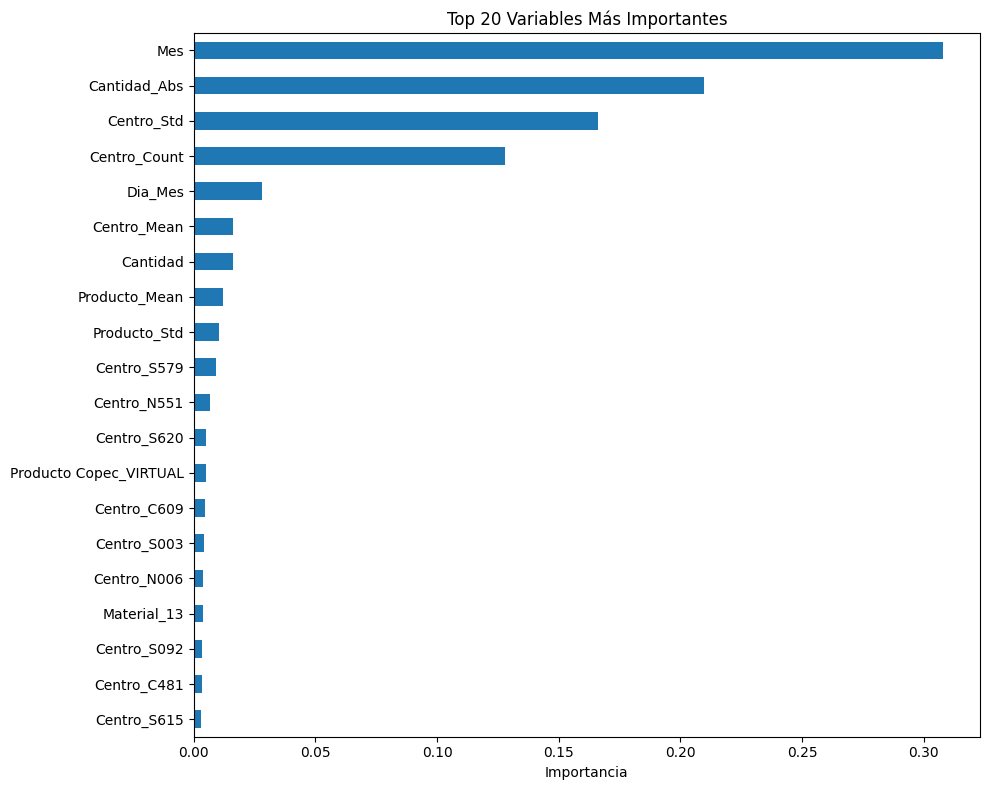

In [14]:
## IMPORTANCIA DE CARACTERÍSTICAS

feature_importantes = pd.Series(
    modelo_gbc.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("Top 20 Variables Más Importantes:")
print(feature_importantes.head(20).to_string())

# Visualización
plt.figure(figsize=(10, 8))
feature_importantes.head(20).plot(kind='barh')
plt.xlabel('Importancia')
plt.title('Top 20 Variables Más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

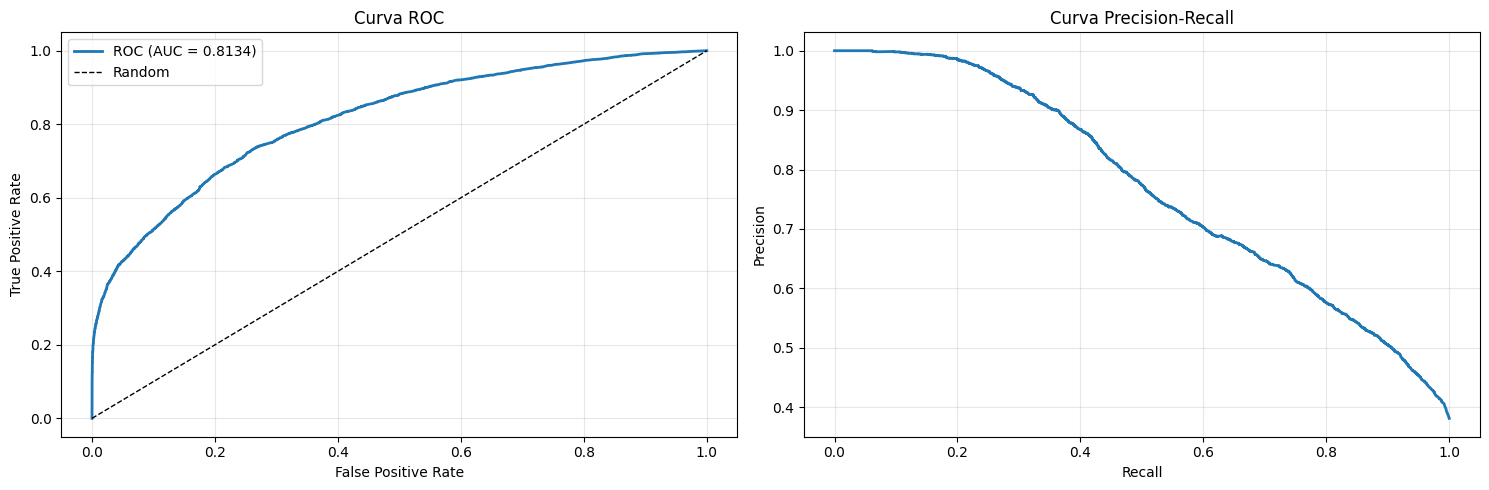

In [15]:
## CURVAS ROC Y PRECISION-RECALL

# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Curva ROC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Curva Precision-Recall
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[1].plot(recall_curve, precision_curve, linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
## GENERAR PREDICCIONES

# Crear dataset para predicción
df_pred = df.copy()

# Preparar features
df_pred_encoded = pd.get_dummies(df_pred,
                                   columns=['Centro', 'Producto Copec', 'Material'],
                                   drop_first=True)

# Alinear columnas con entrenamiento
X_pred = df_pred_encoded.reindex(columns=X_train.columns, fill_value=0)

# Escalar y predecir
X_pred_scaled = scaler.transform(X_pred)
probabilidades_pred = modelo_gbc.predict_proba(X_pred_scaled)[:, 1]

# Agregar probabilidades al dataframe
df_pred['Probabilidad_Descuadre'] = probabilidades_pred

print(f"Predicciones generadas para {len(df_pred):,} registros")

Predicciones generadas para 316,439 registros


In [17]:
## RANKING DE RIESGO

# Define the Config
class Config:
    UMBRAL_ALERTA = 0.5
    UMBRAL_RIESGO = 0.05
    RUTA_SALIDA_MODELO = '/content/drive/MyDrive/SAP_Descuadres_Input/modelo_descuadres.pkl'
    RUTA_SALIDA_REPORTES = '/content/drive/MyDrive/SAP_Descuadres_Input/reportes/'

# Agrupar por periodo y centro
ranking = df_pred.groupby(['Periodo', 'Centro']).agg(
    Probabilidad_Maxima=('Probabilidad_Descuadre', 'max'),
    Probabilidad_Promedio=('Probabilidad_Descuadre', 'mean'),
    Num_Transacciones=('Centro', 'size')
).reset_index()

# Filtrar solo alertas de riesgo (probabilidad > umbral)
ranking_filtrado = ranking[ranking['Probabilidad_Maxima'] > Config.UMBRAL_ALERTA].copy()

# Clasificar nivel de riesgo
ranking_filtrado['Nivel_Riesgo'] = pd.cut(
    ranking_filtrado['Probabilidad_Maxima'],
    bins=[0.5, 0.7, 0.85, 1.0],
    labels=['MEDIO', 'ALTO', 'CRÍTICO']
)

# Ordenar por probabilidad
ranking_filtrado = ranking_filtrado.sort_values('Probabilidad_Maxima', ascending=False)

# Formatear para visualización
ranking_display = ranking_filtrado.copy()
ranking_display['Probabilidad_Maxima'] = (ranking_display['Probabilidad_Maxima'] * 100).round(2).astype(str) + '%'
ranking_display['Probabilidad_Promedio'] = (ranking_display['Probabilidad_Promedio'] * 100).round(2).astype(str) + '%'
ranking_display['Periodo'] = ranking_display['Periodo'].astype(str)

print(f"Total de Centros en Riesgo: {len(ranking_filtrado)}")
print(f"Distribución por Nivel de Riesgo:")
print(ranking_filtrado['Nivel_Riesgo'].value_counts())
print(f"Top 20 Centros con Mayor Riesgo:")
print(ranking_display.head(20).to_string(index=False))

Total de Centros en Riesgo: 3044
Distribución por Nivel de Riesgo:
Nivel_Riesgo
MEDIO      1839
CRÍTICO     790
ALTO        415
Name: count, dtype: int64
Top 20 Centros con Mayor Riesgo:
Periodo Centro Probabilidad_Maxima Probabilidad_Promedio  Num_Transacciones Nivel_Riesgo
2025-12   G348              97.48%                94.74%                 53      CRÍTICO
2025-12   S086              97.14%                86.94%                 55      CRÍTICO
2025-12   N551              96.97%                91.02%                 52      CRÍTICO
2025-12   S615              96.91%                86.42%                 42      CRÍTICO
2025-12   S579               96.9%                94.36%                 44      CRÍTICO
2025-12   N282              96.83%                90.46%                 69      CRÍTICO
2025-12   S089              96.76%                91.23%                 65      CRÍTICO
2025-12   S092              96.62%                 89.3%                 57      CRÍTICO
2024-12   N2

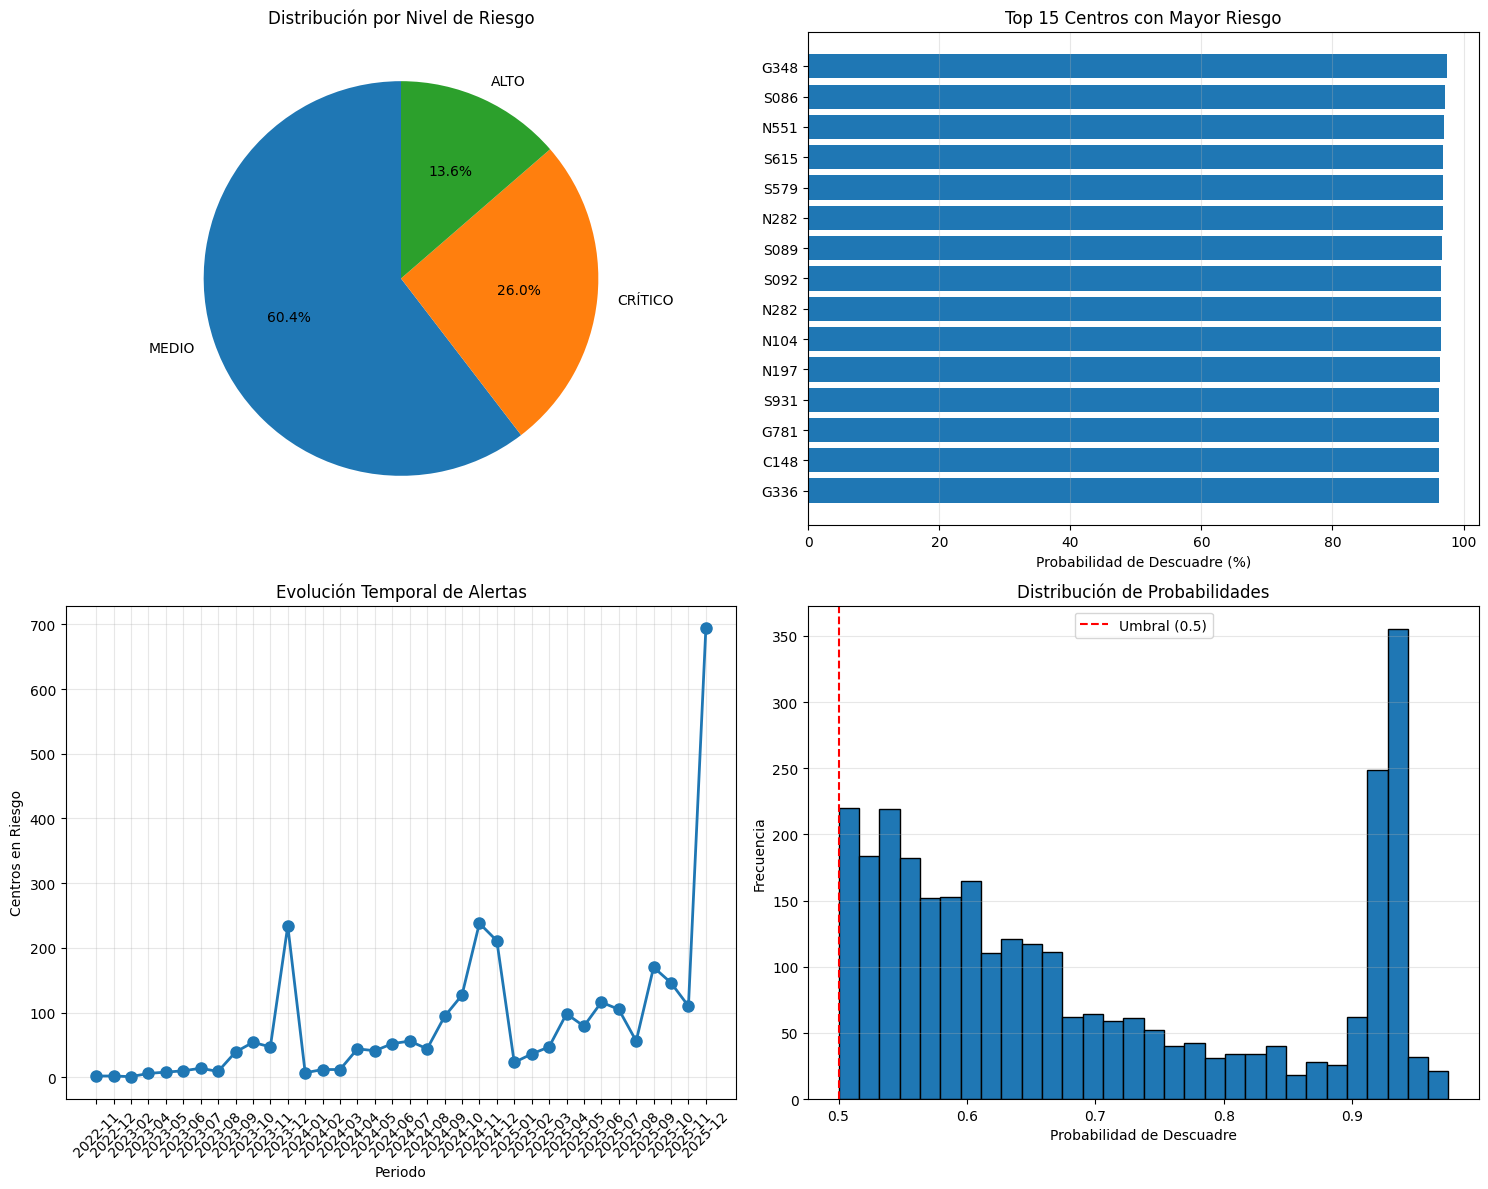

In [18]:
## VISUALIZACIONES DEL RANKING

# Crear figura con múltiples gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Distribución de niveles de riesgo
nivel_counts = ranking_filtrado['Nivel_Riesgo'].value_counts()
axes[0, 0].pie(nivel_counts.values, labels=nivel_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribución por Nivel de Riesgo')

# Gráfico 2: Top 15 centros
top15 = ranking_filtrado.head(15)
axes[0, 1].barh(range(len(top15)), top15['Probabilidad_Maxima'] * 100)
axes[0, 1].set_yticks(range(len(top15)))
axes[0, 1].set_yticklabels(top15['Centro'])
axes[0, 1].set_xlabel('Probabilidad de Descuadre (%)')
axes[0, 1].set_title('Top 15 Centros con Mayor Riesgo')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Gráfico 3: Timeline de riesgos
timeline = ranking_filtrado.groupby('Periodo').size()
axes[1, 0].plot(range(len(timeline)), timeline.values, marker='o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Periodo')
axes[1, 0].set_ylabel('Centros en Riesgo')
axes[1, 0].set_title('Evolución Temporal de Alertas')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(len(timeline)))
axes[1, 0].set_xticklabels([str(p) for p in timeline.index], rotation=45)

# Gráfico 4: Distribución de probabilidades
axes[1, 1].hist(ranking_filtrado['Probabilidad_Maxima'], bins=30, edgecolor='black')
axes[1, 1].set_xlabel('Probabilidad de Descuadre')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Probabilidades')
axes[1, 1].axvline(Config.UMBRAL_ALERTA, color='red', linestyle='--', label=f'Umbral ({Config.UMBRAL_ALERTA})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [20]:
## GUARDAR MODELO Y RESULTADOS
import os

modelo_completo = {
    'modelo': modelo_gbc,
    'scaler': scaler,
    'columnas_entrenamiento': X_train.columns.tolist(),
    'umbral_riesgo': Config.UMBRAL_RIESGO,
    'umbral_alerta': Config.UMBRAL_ALERTA,
    'metricas': {
        'roc_auc': roc_auc,
        'tasa_fn': tasa_fn,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    'importancia_feature': feature_importantes.to_dict(),
    'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Guardar el modelo
with open(Config.RUTA_SALIDA_MODELO, 'wb') as f:
    pickle.dump(modelo_completo, f)

print(f"Modelo guardado en: {Config.RUTA_SALIDA_MODELO}")

# Guardar ranking en Excel
fecha_actual = datetime.now().strftime('%Y%m%d_%H%M%S')
ruta_excel = f"{Config.RUTA_SALIDA_REPORTES}ranking_riesgo_{fecha_actual}.xlsx"

with pd.ExcelWriter(ruta_excel, engine='openpyxl') as writer:
    # Hoja 1: Ranking completo
    ranking_display.to_excel(writer, sheet_name='Ranking Riesgo', index=False)

    # Hoja 2: Resumen
    resumen = pd.DataFrame({
        'Métrica': [
            'Total Centros en Riesgo',
            'Centros Riesgo Crítico',
            'Centros Riesgo Alto',
            'Centros Riesgo Medio',
            'ROC-AUC Score',
            'Tasa Falsos Negativos',
            'Fecha Generación'
        ],
        'Valor': [
            len(ranking_filtrado),
            len(ranking_filtrado[ranking_filtrado['Nivel_Riesgo'] == 'CRÍTICO']),
            len(ranking_filtrado[ranking_filtrado['Nivel_Riesgo'] == 'ALTO']),
            len(ranking_filtrado[ranking_filtrado['Nivel_Riesgo'] == 'MEDIO']),
            f"{roc_auc:.4f}",
            f"{tasa_fn:.2%}",
            datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        ]
    })
    resumen.to_excel(writer, sheet_name='Resumen', index=False)

    # Hoja 3: Top features
    top_features = feature_importantes.head(20).reset_index()
    top_features.columns = ['Variable', 'Importancia']
    top_features.to_excel(writer, sheet_name='Top Features', index=False)

print(f"Ranking guardado en: {ruta_excel}")

Modelo guardado en: /content/drive/MyDrive/SAP_Descuadres_Input/modelo_descuadres.pkl
Ranking guardado en: /content/drive/MyDrive/SAP_Descuadres_Input/reportes/ranking_riesgo_20251228_154634.xlsx
